In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from pandas.plotting import parallel_coordinates
from fuzzywuzzy import process
import networkx as nx


# call_Apriori_def

In [2]:
from Apriori_def import (
    read_data,
    columns_info,
    bar_plot,
    transaction_to_df,
    plot_item_frequency,
    association_rules_apriori,
    get_top_related_products,
    plot_enhanced_product_network,
    plot_rule_px_scatter,
    plot_rule_scatter,
    plot_rule_polyfit
)

# read_data

In [3]:
df = read_data(r"Supermarket_data.csv")
print(df.shape)
df.head(3)

the DataFrame have 759 duplicates rows
the DataFrame without duplicates rows
Data read successfully from Supermarket_data.csv
(38006, 3)


,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit


In [4]:
columns_info(df)

,names,dtypes,unique,n_unique,number_of_rows,number_of_null
0,Member_number,int64,"[1808, 2552, 2300, 1187, 3037, 4941, 4501, 380...",3898,38006,0
1,Date,object,"[21-07-2015, 05-01-2015, 19-09-2015, 12-12-201...",728,38006,0
2,itemDescription,object,"[tropical fruit, whole milk, pip fruit, other ...",167,38006,0


# from the data

In [5]:
def rfm_analysis(df):
    # Convert date to datetime if not already
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    
    # Calculate Recency, Frequency, Monetary
    today = df['Date'].max()
    
    rfm = df.groupby('Member_number').agg({
        'Date': lambda x: (today - x.max()).days,  # Recency
        'Member_number': 'count',  # Frequency
    }).rename(columns={
        'Date': 'Recency',
        'Member_number': 'Frequency'
    })
    
    # Score from 1-5
    rfm['R'] = pd.qcut(rfm['Recency'], q=5, labels=[5,4,3,2,1])
    rfm['F'] = pd.qcut(rfm['Frequency'], q=5, labels=[1,2,3,4,5])
    
    return rfm

rfm = rfm_analysis(df)
rfm.head(10)

,Recency,Frequency,R,F
Member_number,,,,
1000,35,13,5,4
1001,242,12,2,4
1002,122,8,3,2
1003,323,7,2,2
1004,28,21,5,5
1005,706,3,1,1
1006,199,14,2,4
1008,88,11,4,4
1009,86,9,4,3


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Total Number of Items Sold')]

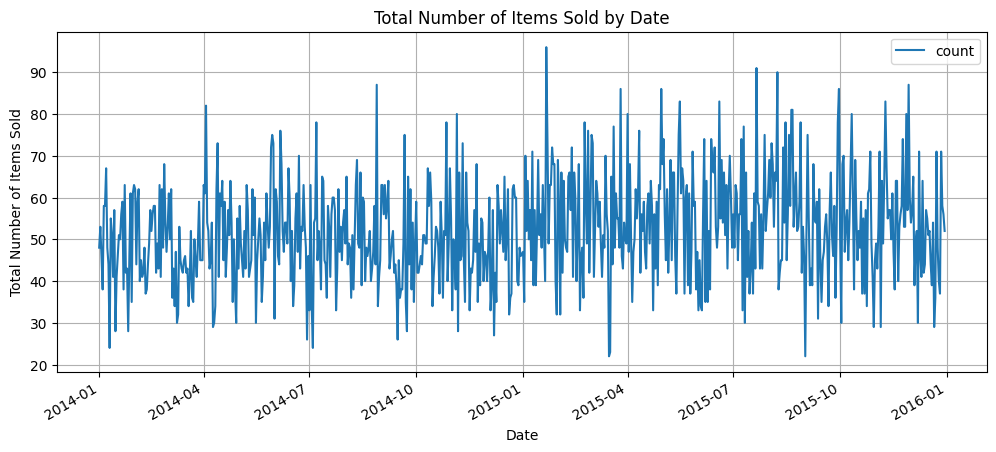

In [6]:
df.groupby(['Date'])['itemDescription'].agg(['count']).plot(figsize=(12,5), grid=True, title="Total Number of Items Sold by Date").set(xlabel="Date", ylabel="Total Number of Items Sold")

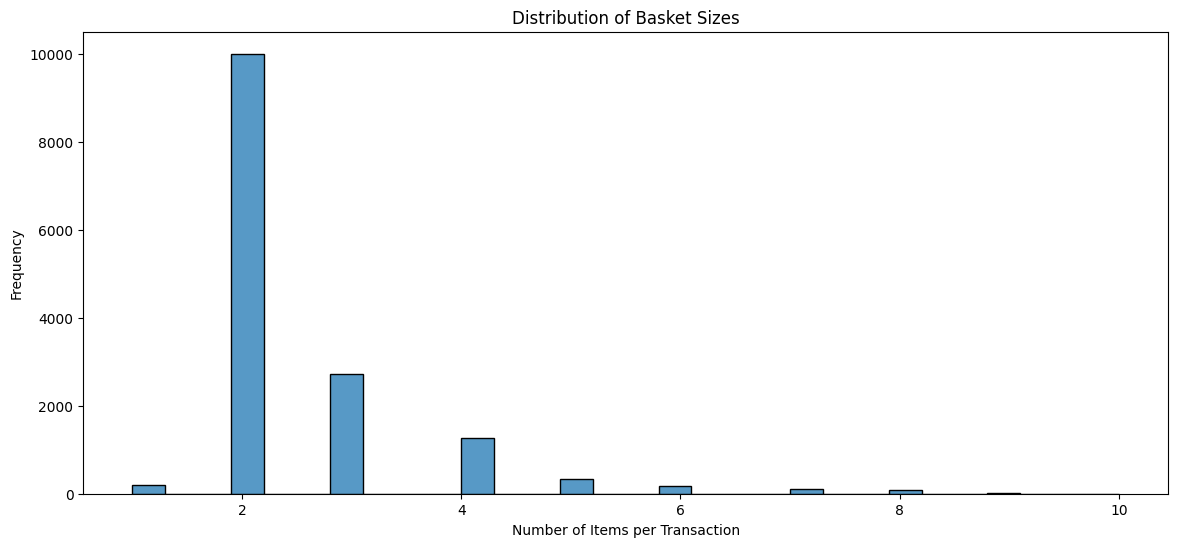

In [7]:
# Calculate basket sizes
basket_sizes = df.groupby(['Member_number', 'Date']).size()
plt.figure(figsize=(14,6))
sns.histplot(basket_sizes, bins=30)
plt.title('Distribution of Basket Sizes')
plt.xlabel('Number of Items per Transaction')
plt.ylabel('Frequency')
plt.show()


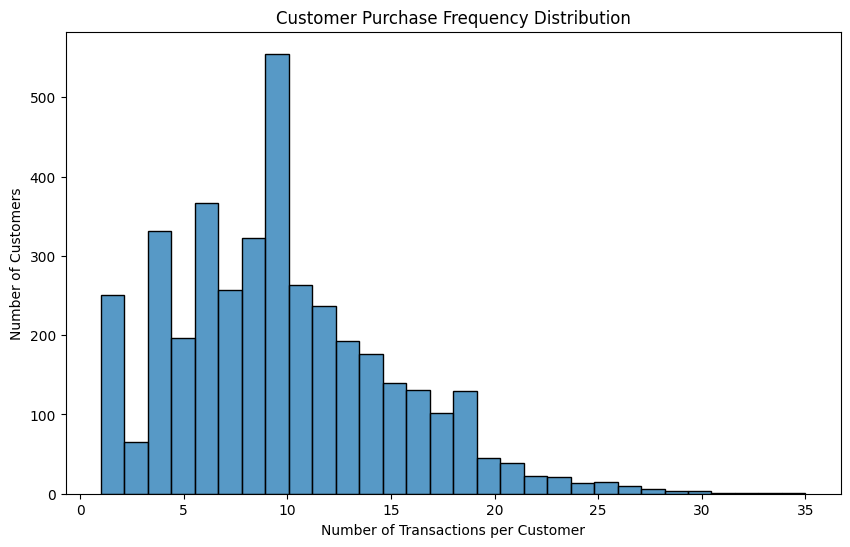

In [8]:
# Analyze customer purchase frequency
customer_frequency = df.groupby('Member_number').size()
plt.figure(figsize=(10,6))
sns.histplot(customer_frequency, bins=30)
plt.title('Customer Purchase Frequency Distribution')
plt.xlabel('Number of Transactions per Customer')
plt.ylabel('Number of Customers')
plt.show()


In [9]:
d=df.set_index(['Date'])
d.index=pd.to_datetime(d.index ,dayfirst=True)

total_items = len(d)

total_days = len(np.unique(d.index.date))

total_months = len(np.unique(d.index.month))

average_items = total_items / total_days

unique_items = d['itemDescription'].unique().size

print("There are {} unique items sold ".format(unique_items))
print("Total {} items sold in {} days throughout {} months".format(total_items, total_days, total_months))
print("With an average of {} items sold daily".format(average_items))

There are 167 unique items sold 
Total 38006 items sold in 728 days throughout 12 months
With an average of 52.206043956043956 items sold daily


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Total Number of Items Sold')]

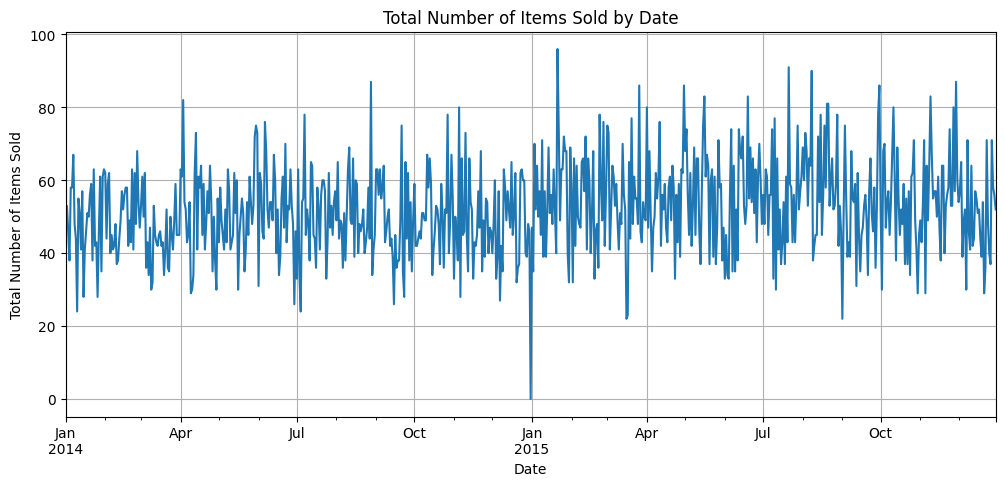

In [10]:
d.resample("D")['itemDescription'].count().plot(figsize=(12,5), grid=True, title="Total Number of Items Sold by Date").set(xlabel="Date", ylabel="Total Number of Items Sold")

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Total Number of Items Sold')]

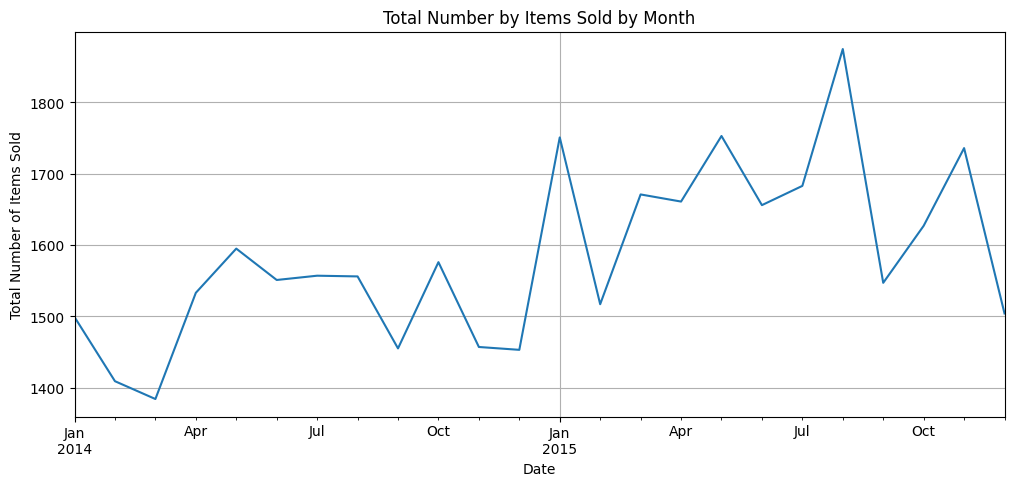

In [11]:
d.resample("ME")['itemDescription'].count().plot(figsize=(12,5), grid=True, title="Total Number by Items Sold by Month").set(xlabel="Date", ylabel="Total Number of Items Sold")

In [12]:
bar_plot(df,'itemDescription')

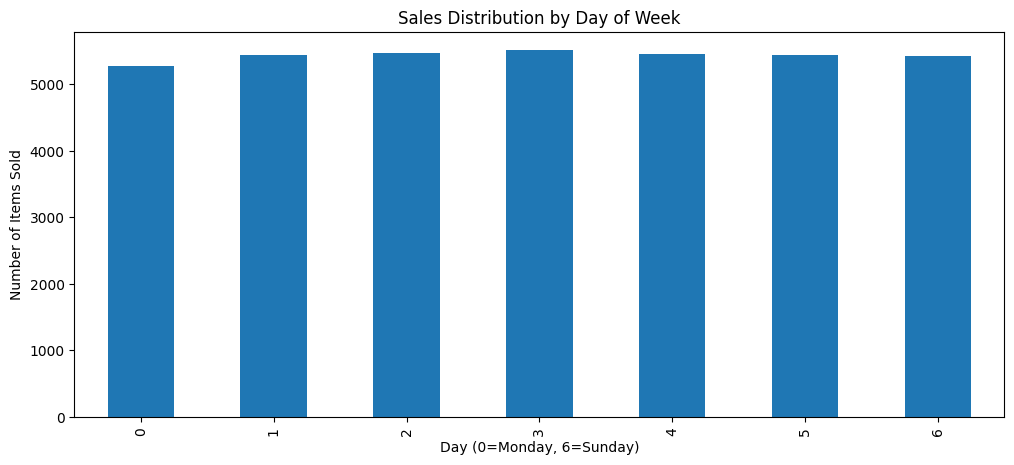

In [13]:
# Weekly patterns
weekly_patterns = d.groupby(d.index.dayofweek)['itemDescription'].count()
plt.figure(figsize=(12,5))
weekly_patterns.plot(kind='bar')
plt.title('Sales Distribution by Day of Week')
plt.xlabel('Day (0=Monday, 6=Sunday)')
plt.ylabel('Number of Items Sold')
plt.show()

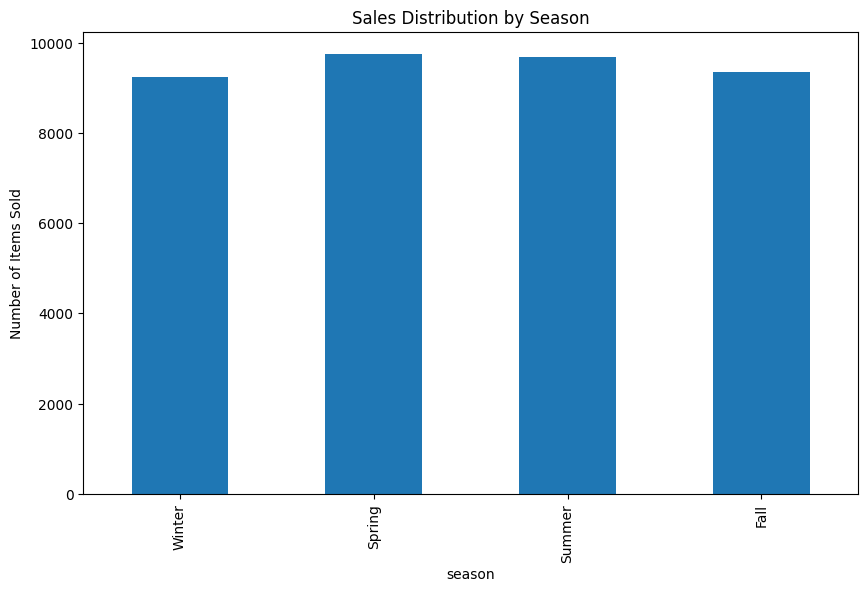

In [14]:
# Add seasonal trends
seasonal = d.copy()
seasonal['month'] = seasonal.index.month
seasonal['season'] = pd.cut(
    seasonal['month'], 
    bins=[0, 3, 6, 9, 12], 
    labels=['Winter', 'Spring', 'Summer', 'Fall']
)
# Group by season with observed=True to avoid warning
seasonal_analysis = seasonal.groupby('season', observed=True)['itemDescription'].count()

# Plotting
seasonal_analysis.plot(kind='bar', figsize=(10, 6))
plt.title('Sales Distribution by Season')
plt.ylabel('Number of Items Sold')
plt.show()

# get transactions

In [15]:
data_group = df.groupby(['Member_number', 'Date'])['itemDescription'].apply(lambda x: ','.join(x))
data_group

Member_number  Date      
1000           2014-06-24                    whole milk,pastry,salty snack
               2015-03-15    sausage,whole milk,semi-finished bread,yogurt
               2015-05-27                          soda,pickled vegetables
               2015-07-24                      canned beer,misc. beverages
               2015-11-25                         sausage,hygiene articles
                                                 ...                      
4999           2015-05-16                   butter milk,whipped/sour cream
               2015-12-26                              bottled water,herbs
5000           2014-03-09                     fruit/vegetable juice,onions
               2014-11-16                    bottled beer,other vegetables
               2015-02-10         soda,root vegetables,semi-finished bread
Name: itemDescription, Length: 14963, dtype: object

In [16]:
# # If you want to come up with all the purchases that a person has purchased and This is an error in this example.
# new_df = df.groupby(['Member_number', 'itemDescription']).size().unstack().fillna(0)

In [17]:
df_group = pd.DataFrame(data_group).reset_index()
df_group.drop(['Member_number', 'Date'], axis=1, inplace=True)
df_group

,itemDescription
0,"whole milk,pastry,salty snack"
1,"sausage,whole milk,semi-finished bread,yogurt"
2,"soda,pickled vegetables"
3,"canned beer,misc. beverages"
4,"sausage,hygiene articles"
...,...
14958,"butter milk,whipped/sour cream"
14959,"bottled water,herbs"
14960,"fruit/vegetable juice,onions"
14961,"bottled beer,other vegetables"


In [18]:
transactions = df_group['itemDescription'].apply(lambda x : x.split(','))
print(transactions.shape)
transactions.head(3)

(14963,)


0                    [whole milk, pastry, salty snack]
1    [sausage, whole milk, semi-finished bread, yog...
2                           [soda, pickled vegetables]
Name: itemDescription, dtype: object

In [19]:
transactions[0]

['whole milk', 'pastry', 'salty snack']

In [20]:
te_df = transaction_to_df(transactions)
print(te_df.shape)
te_df.head(3)

(14963, 167)


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Visualization

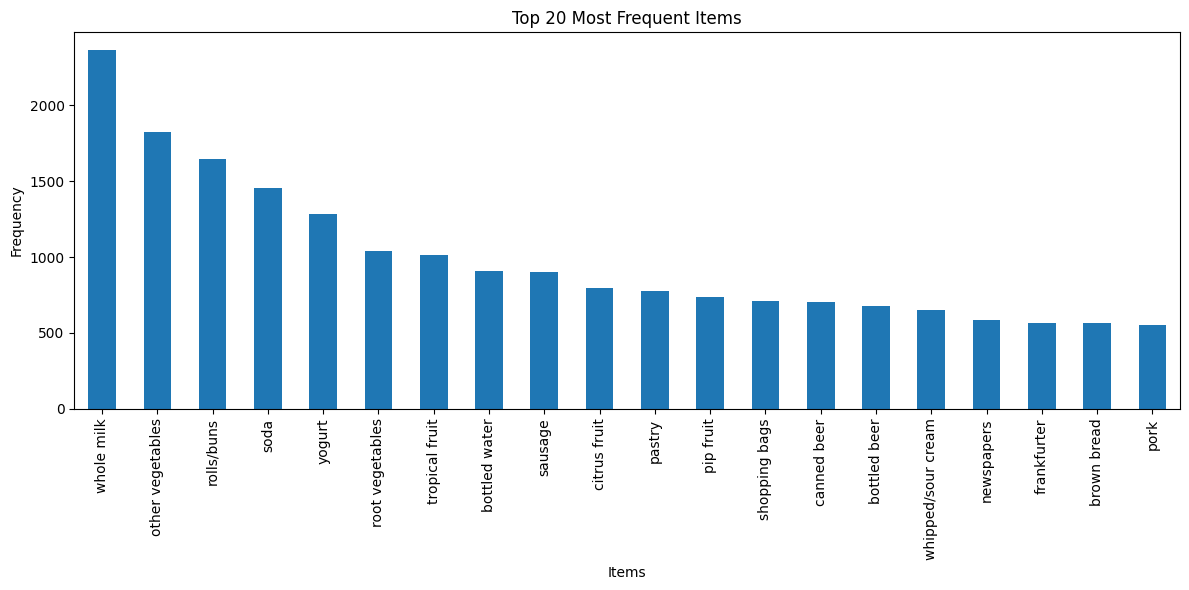

In [21]:
plot_item_frequency(te_df)

In [22]:
pf = te_df.describe()
pf

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
count,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,...,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,14903,14643,14941,14934,14960,14959,14842,14946,14455,14637,...,14883,14912,14686,14309,14955,14604,14788,12600,13678,14903


In [23]:
f = pf.iloc[0] - pf.iloc[3] # count - freq
f

Instant food products      60
UHT-milk                  320
abrasive cleaner           22
artif. sweetener           29
baby cosmetics              3
                         ... 
white bread               359
white wine                175
whole milk               2363
yogurt                   1285
zwieback                   60
Length: 167, dtype: object

In [24]:
a = f.tolist()
b = list(f.index)
item = pd.DataFrame([[a[r],b[r]]for r in range(len(a))], columns=['Count','Item'])
item = item.sort_values(['Count'], ascending=False).head(50)

In [25]:
fig = px.treemap(item, path=['Item'], values='Count')
fig.show()

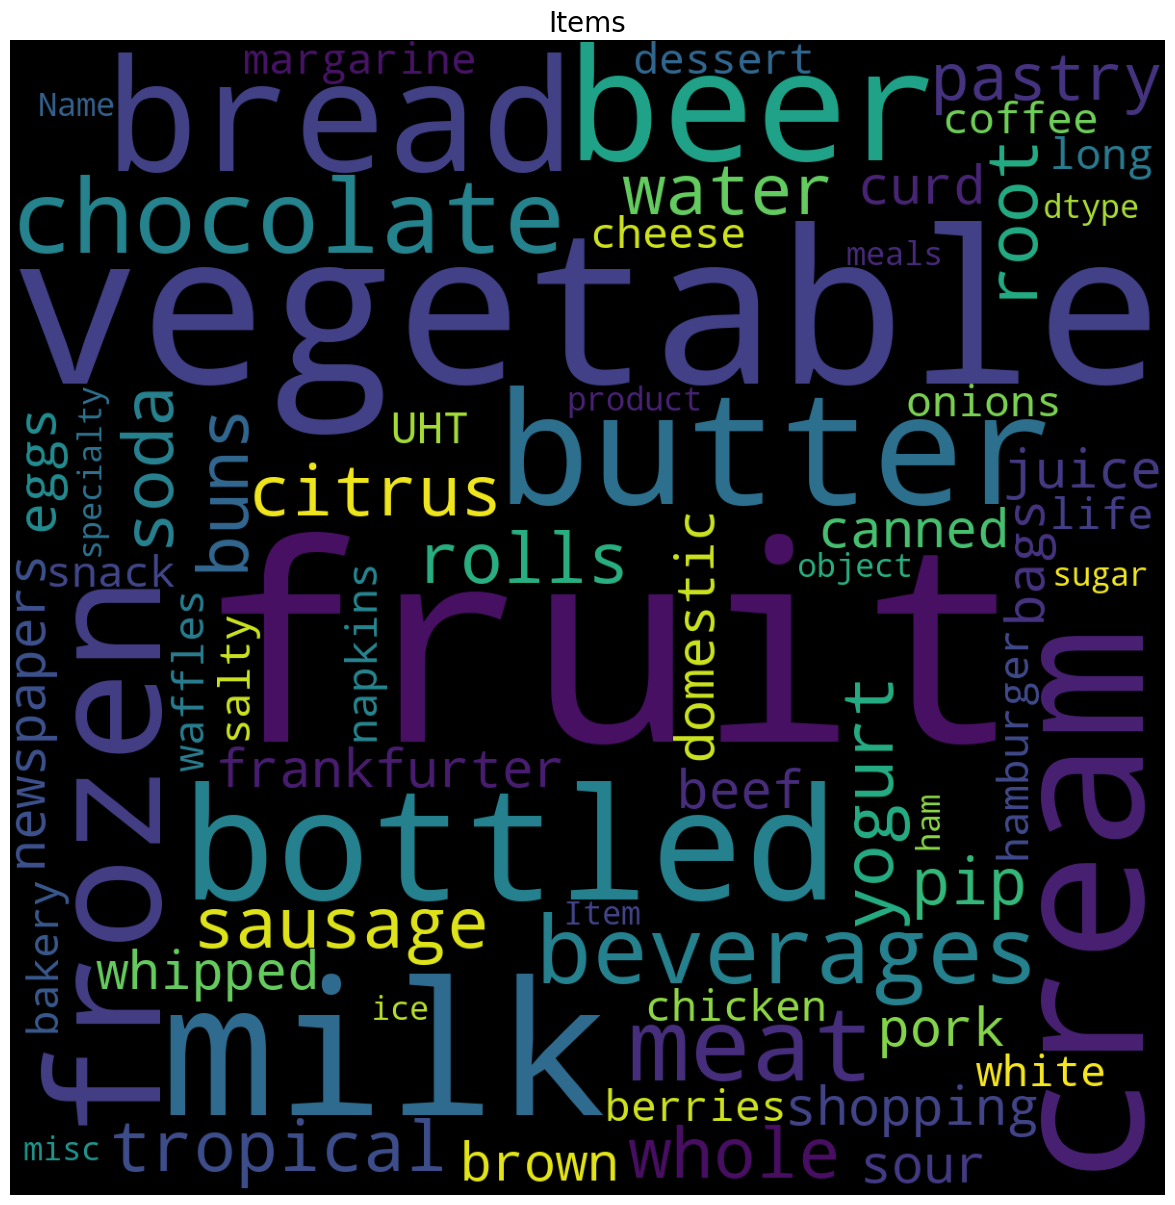

In [26]:
plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'black', width = 1200,  height = 1200, max_words = 100).generate(str(item['Item']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Items',fontsize = 20)
plt.show()

# association_rules with apriori

In [27]:
freq_items, rules = association_rules_apriori(te_df, min_support = 0.001, min_threshold = 0.001, metric = 'lift')

Processing 28 combinations | Sampling itemset size 4e 3


In [28]:
print(freq_items.shape)
freq_items.head(3)

(750, 3)


,support,itemsets,length
0,0.004010,(Instant food products),1
1,0.021386,(UHT-milk),1
2,0.001470,(abrasive cleaner),1


In [29]:
print(rules.shape)
rules.head(3)

(1238, 10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(UHT-milk),(bottled water),0.021386,0.060683,0.001069,0.050000,0.823954,-0.000228,0.988755,-0.179204
1,(bottled water),(UHT-milk),0.060683,0.021386,0.001069,0.017621,0.823954,-0.000228,0.996168,-0.185312
2,(UHT-milk),(other vegetables),0.021386,0.122101,0.002139,0.100000,0.818993,-0.000473,0.975443,-0.184234



Top 5 products frequently bought with 'whole milk':
          related_product      lift  confidence
1108  semi-finished bread  1.114825    0.010580
584             detergent  1.030824    0.008887
728                   ham  1.014142    0.017351
148          bottled beer  0.999330    0.045281
654           frozen fish  0.993287    0.006771


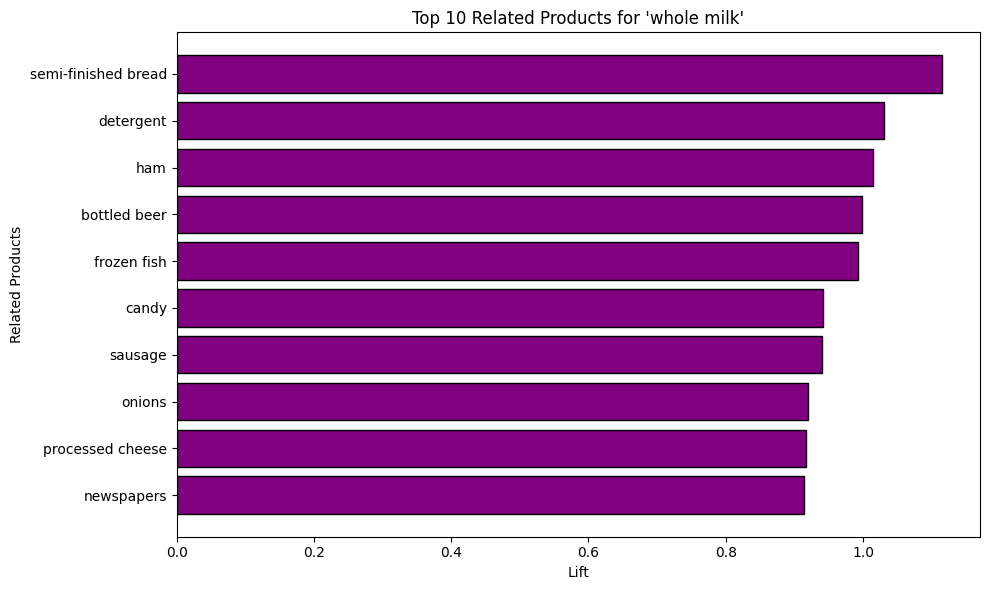

In [30]:
get_top_related_products(rules, "whole milk", plot_output=True)


Product 'beer' not found. Did you mean one of these?
1. canned beer (similarity: 90%)
2. bottled beer (similarity: 90%)
3. beef (similarity: 75%)
Enter the number of your choice or type the product name directly.

Top 5 products frequently bought with 'canned beer':
       related_product      lift  confidence
364        white bread  1.365573    0.032764
217        brown bread  1.362937    0.051282
353        salty snack  1.137802    0.021368
339         newspapers  1.025455    0.039886
332  frozen vegetables  1.017414    0.028490


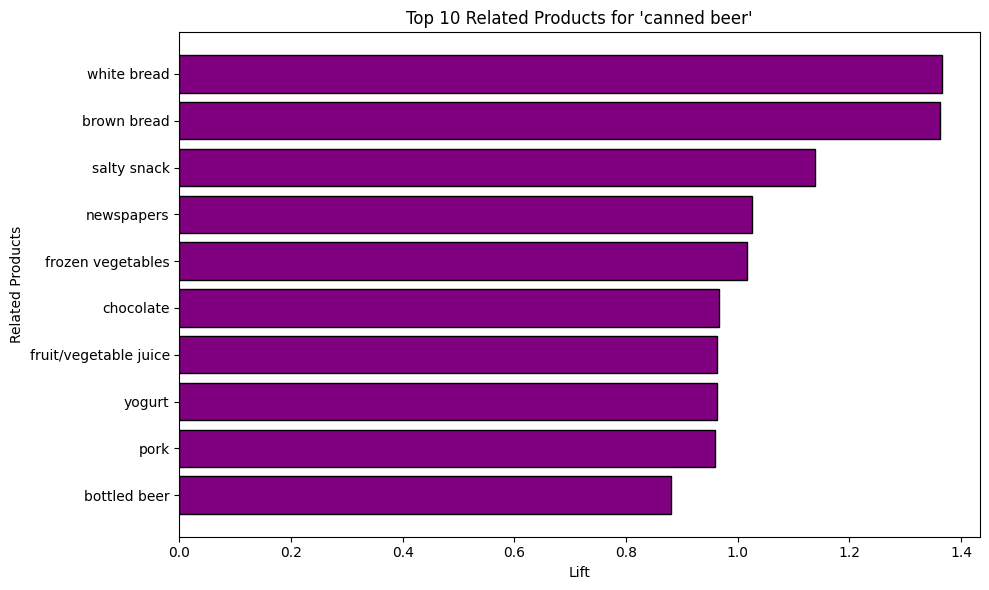

In [31]:
get_top_related_products(rules, "beer", plot_output=True)


Product 'bread' not found. Did you mean one of these?
1. white bread (similarity: 90%)
2. brown bread (similarity: 90%)
3. semi-finished bread (similarity: 90%)
Enter the number of your choice or type the product name directly.

Top 5 products frequently bought with 'brown bread':
    related_product      lift  confidence
216     canned beer  1.362937    0.063943
23             beef  1.203301    0.040853
232            pork  1.197174    0.044405
248     white bread  1.110471    0.026643
224     frankfurter  1.081906    0.040853


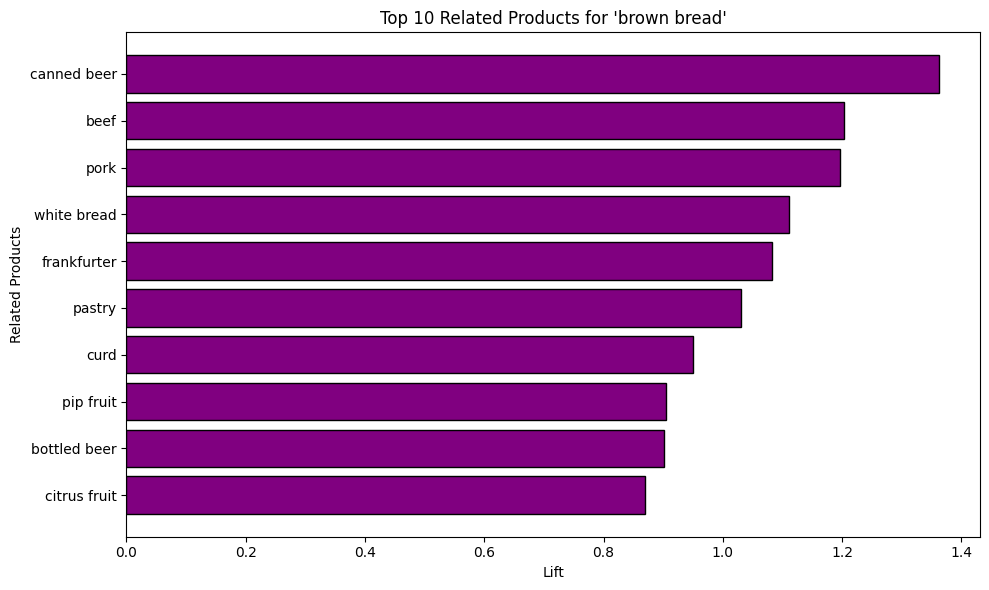

In [32]:
get_top_related_products(rules, "bread", plot_output=True)

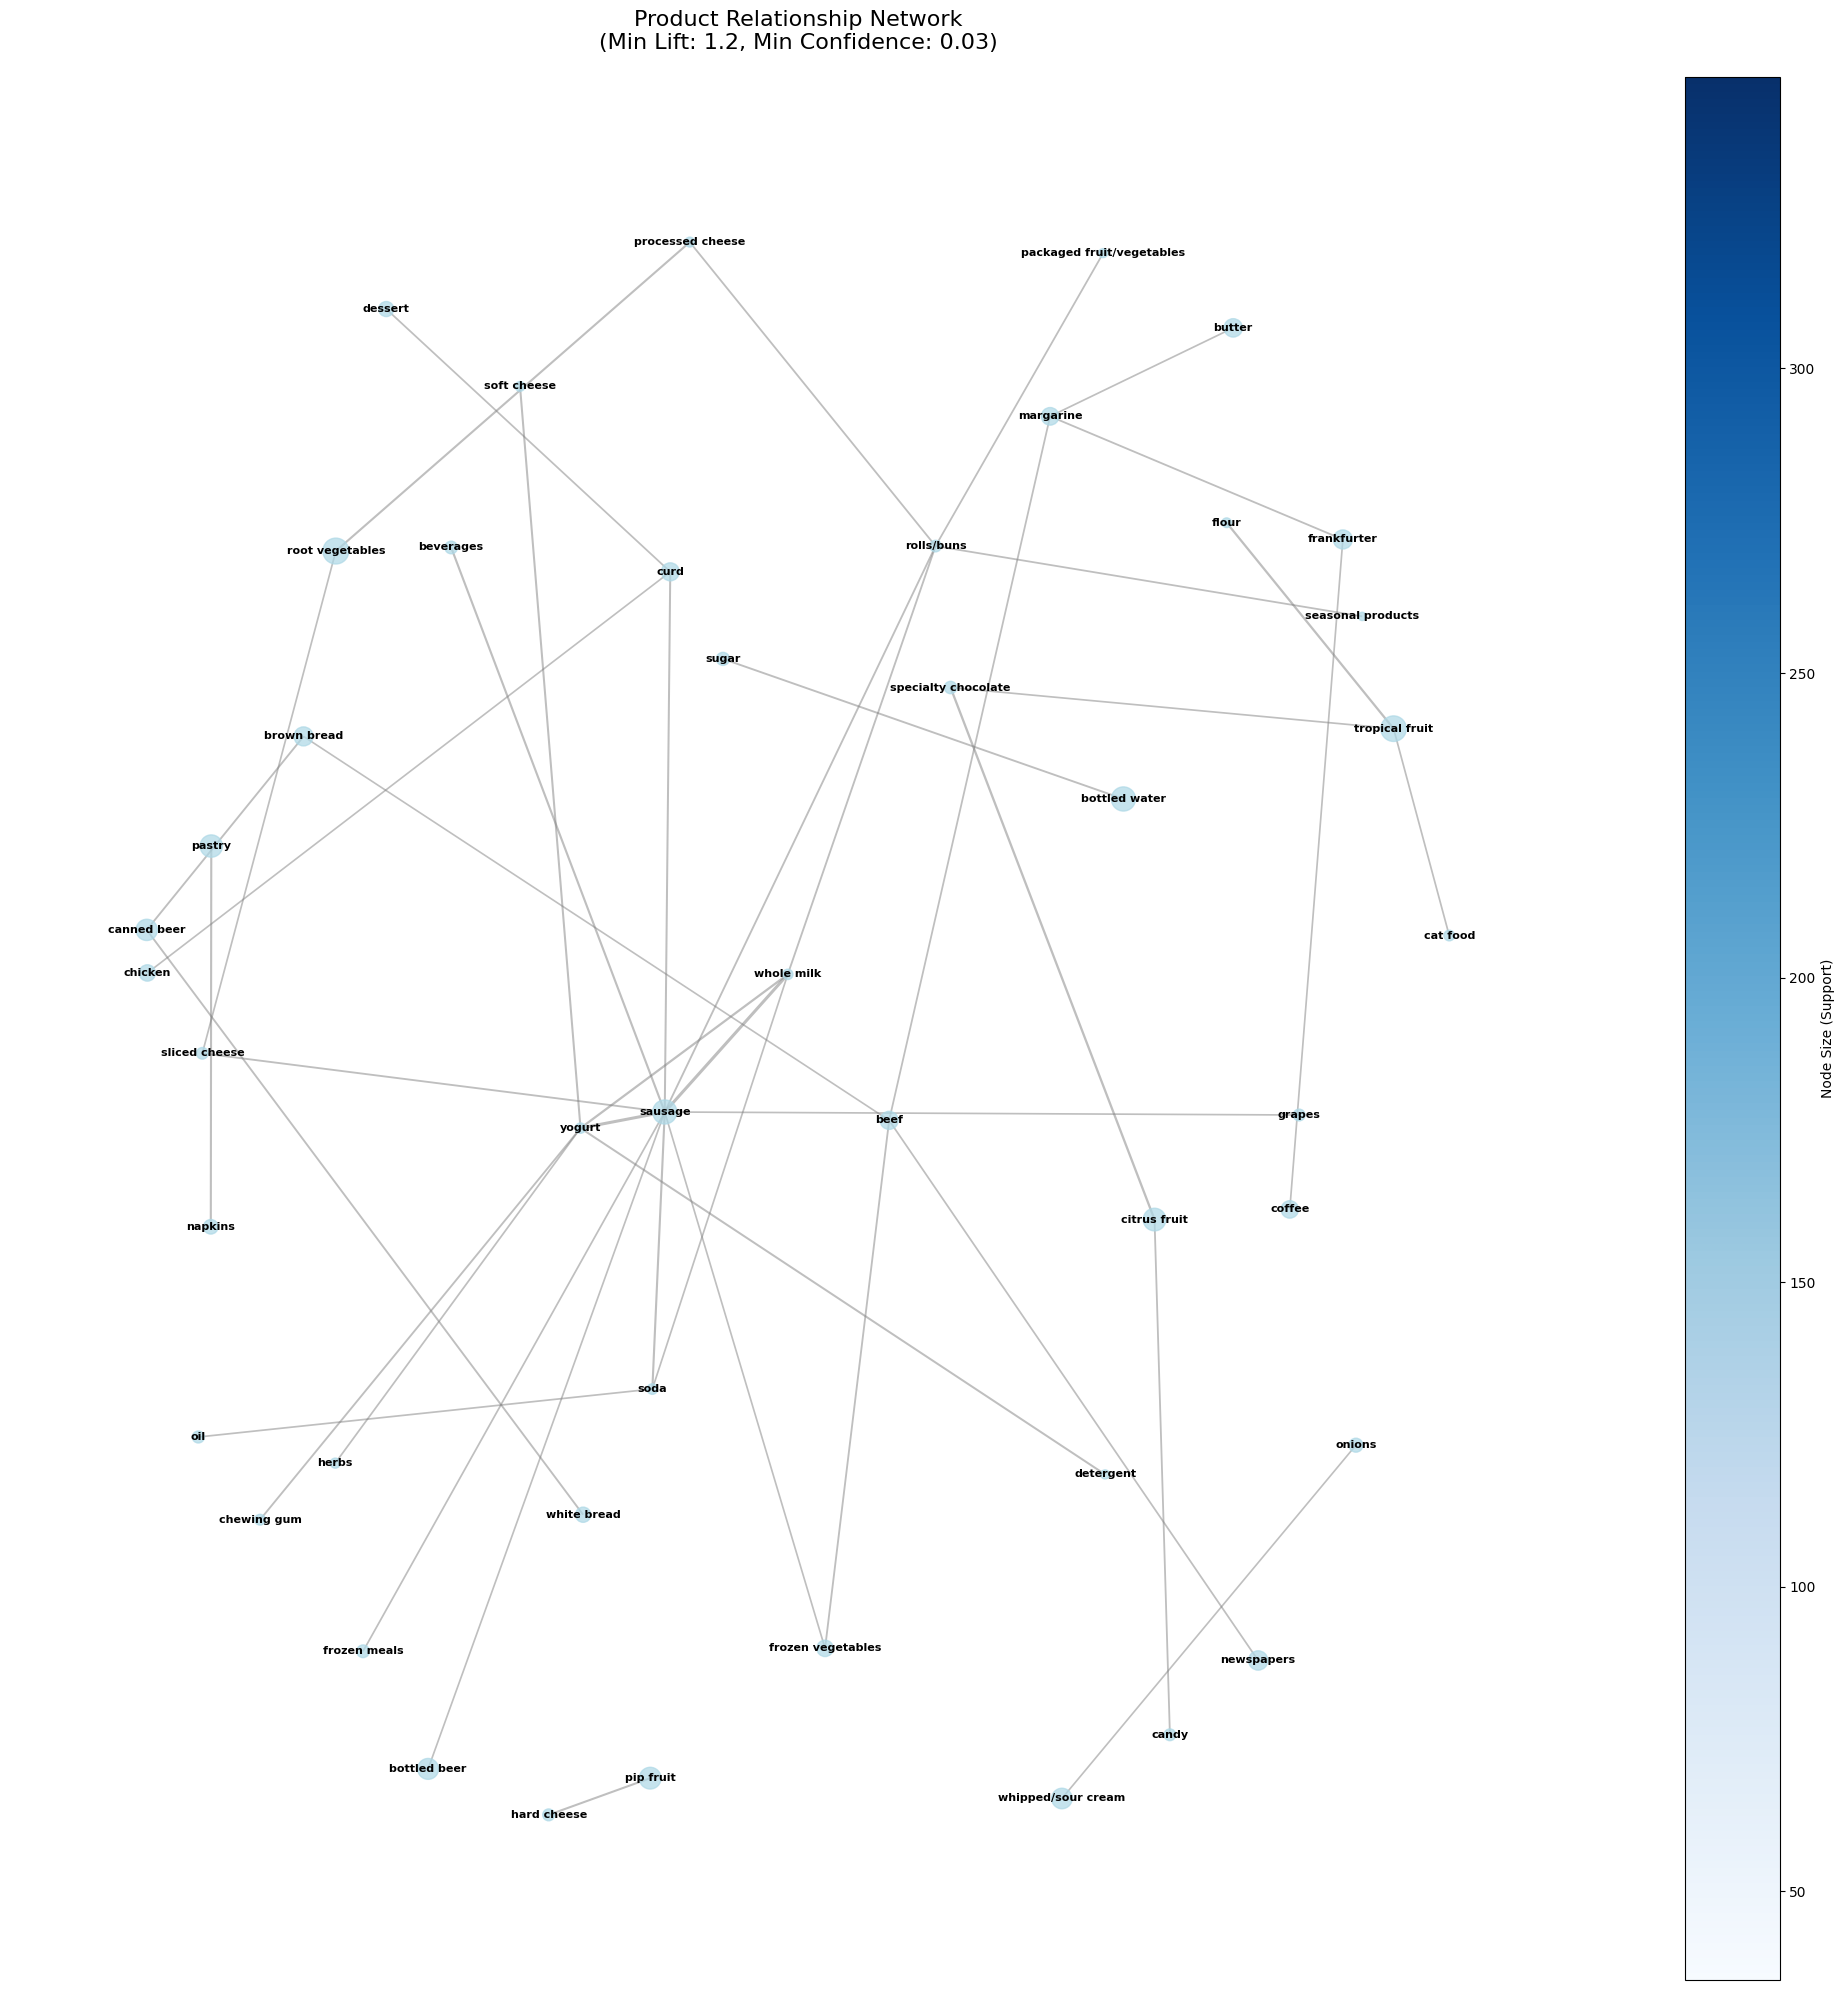

Network Statistics:
Number of nodes: 46
Number of edges: 44
Network density: 0.043

Top 5 Products by Connections:
sausage: 0.244
yogurt: 0.133
rolls/buns: 0.111
beef: 0.089
whole milk: 0.089


In [33]:
# For more relationships
plot_enhanced_product_network(rules, min_lift=1.2, min_confidence=0.03)

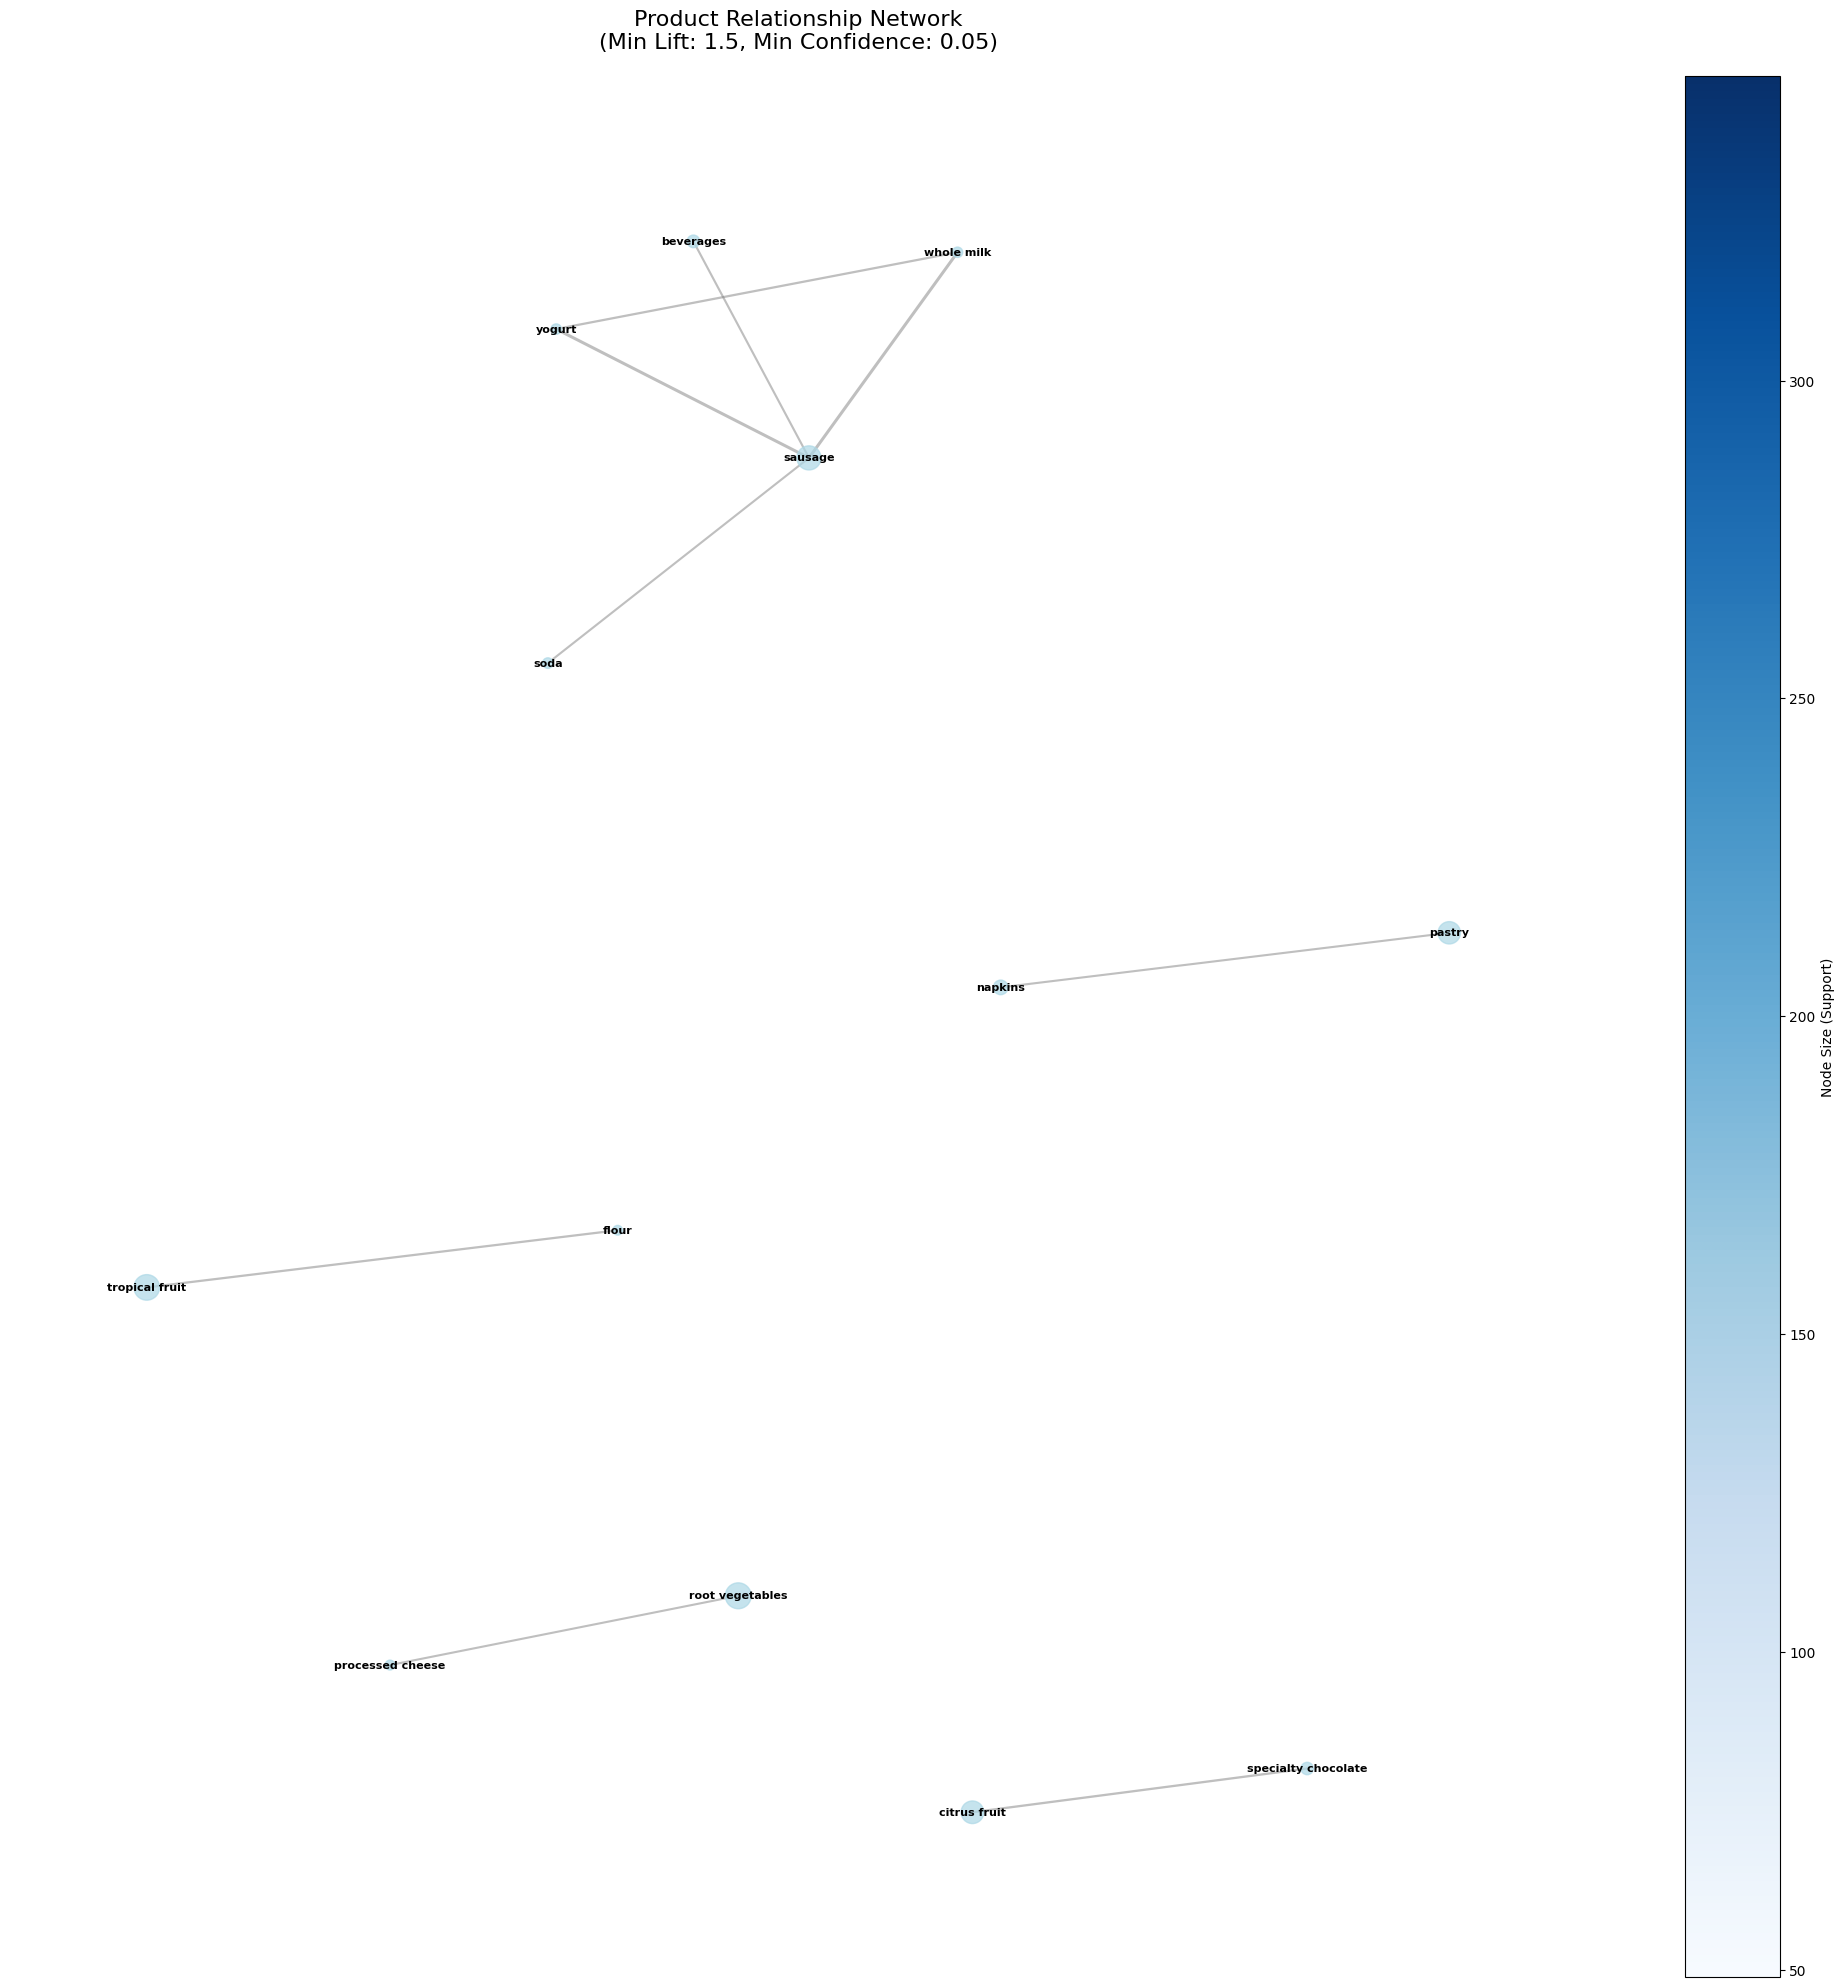

Network Statistics:
Number of nodes: 13
Number of edges: 9
Network density: 0.115

Top 5 Products by Connections:
sausage: 0.333
whole milk: 0.167
yogurt: 0.167
beverages: 0.083
specialty chocolate: 0.083


In [34]:
# For some relationships
plot_enhanced_product_network(rules)

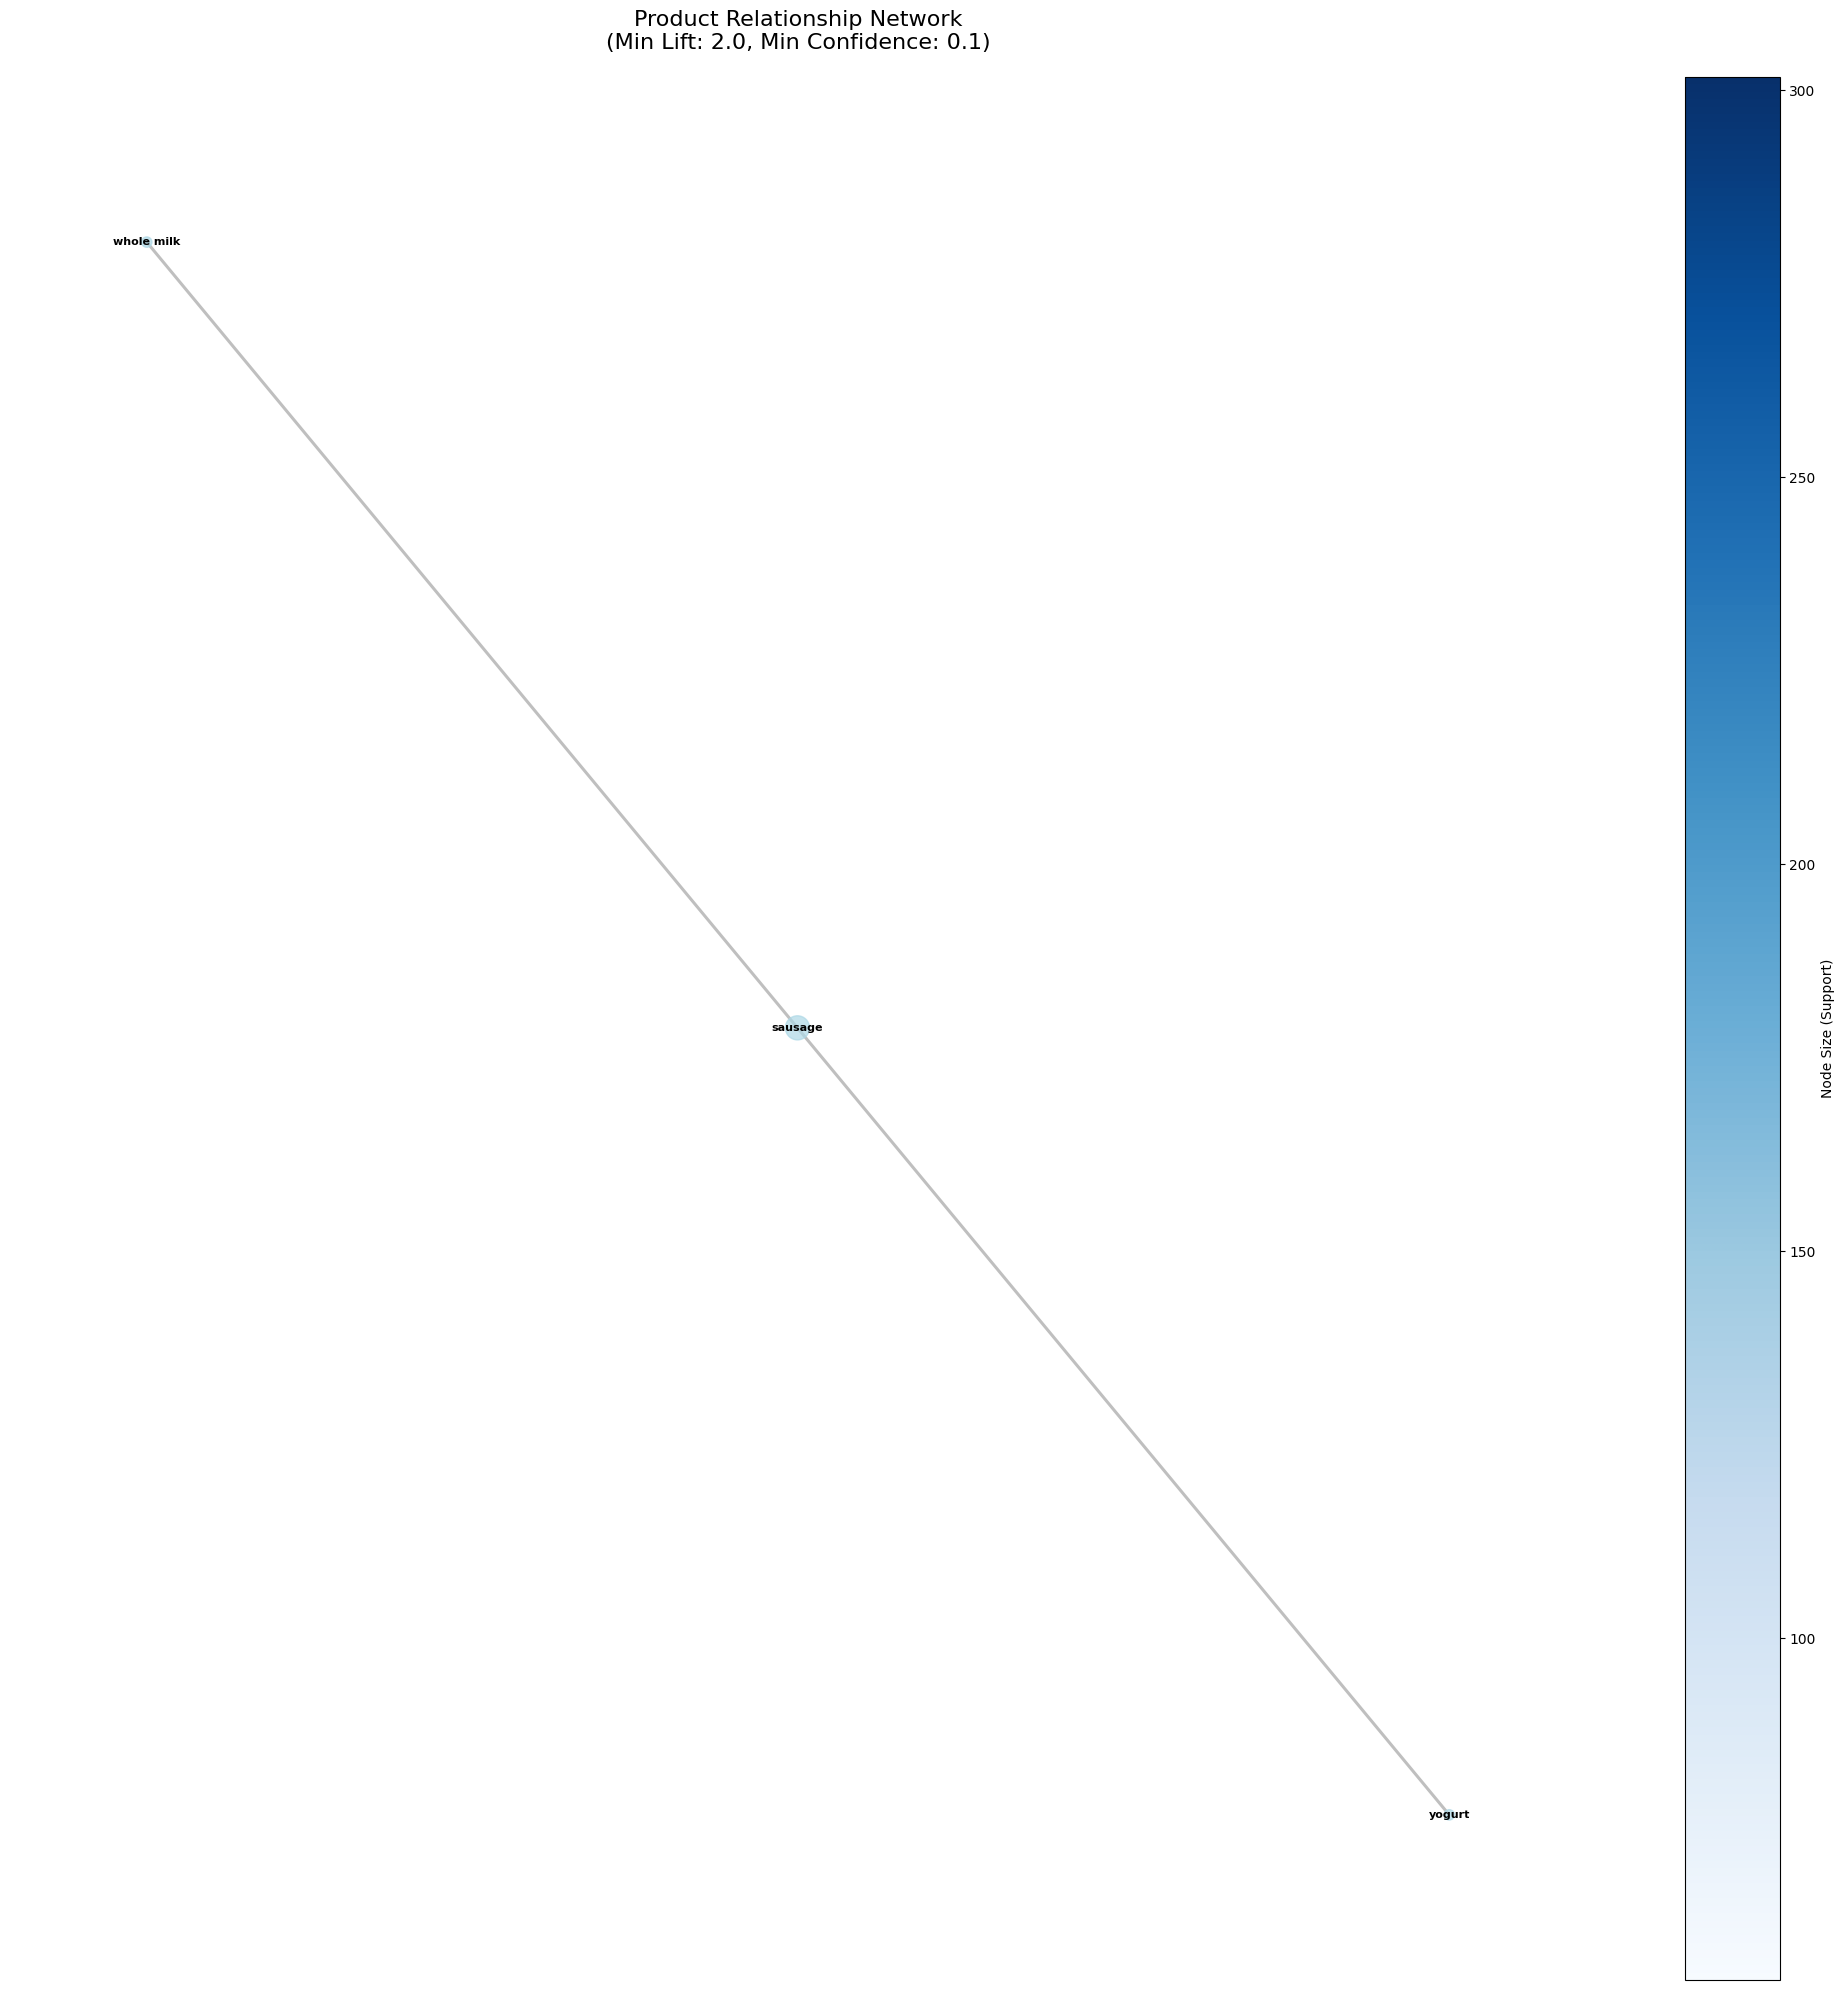

Network Statistics:
Number of nodes: 3
Number of edges: 2
Network density: 0.667

Top 5 Products by Connections:
sausage: 1.000
whole milk: 0.500
yogurt: 0.500


In [35]:
# For fewer, stronger relationships
plot_enhanced_product_network(rules, min_lift=2.0, min_confidence=0.1)

In [36]:
rules.sort_values('lift',ascending = False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1235,(sausage),"(whole milk, yogurt)",0.060349,0.011161,0.001470,0.024363,2.182917,0.000797,1.013532,0.576701
1234,"(whole milk, yogurt)",(sausage),0.011161,0.060349,0.001470,0.131737,2.182917,0.000797,1.082219,0.548014
1232,"(sausage, whole milk)",(yogurt),0.008955,0.085879,0.001470,0.164179,1.911760,0.000701,1.093681,0.481231
1237,(yogurt),"(sausage, whole milk)",0.085879,0.008955,0.001470,0.017121,1.911760,0.000701,1.008307,0.521727
474,(specialty chocolate),(citrus fruit),0.015973,0.053131,0.001403,0.087866,1.653762,0.000555,1.038081,0.401735


In [37]:
rules.sort_values('confidence',ascending = False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1233,"(sausage, yogurt)",(whole milk),0.005748,0.157923,0.001470,0.255814,1.619866,0.000563,1.131541,0.384877
1209,"(sausage, rolls/buns)",(whole milk),0.005347,0.157923,0.001136,0.212500,1.345594,0.000292,1.069304,0.258214
1227,"(sausage, soda)",(whole milk),0.005948,0.157923,0.001069,0.179775,1.138374,0.000130,1.026642,0.122281
1109,(semi-finished bread),(whole milk),0.009490,0.157923,0.001671,0.176056,1.114825,0.000172,1.022008,0.103985
1222,"(rolls/buns, yogurt)",(whole milk),0.007819,0.157923,0.001337,0.170940,1.082428,0.000102,1.015701,0.076751


In [38]:
rules.sort_values('support',ascending = False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
952,(whole milk),(other vegetables),0.157923,0.122101,0.014837,0.093948,0.769430,-0.004446,0.968928,-0.262461
953,(other vegetables),(whole milk),0.122101,0.157923,0.014837,0.121511,0.769430,-0.004446,0.958551,-0.254477
1057,(rolls/buns),(whole milk),0.110005,0.157923,0.013968,0.126974,0.804028,-0.003404,0.964550,-0.214986
1056,(whole milk),(rolls/buns),0.157923,0.110005,0.013968,0.088447,0.804028,-0.003404,0.976350,-0.224474
1136,(whole milk),(soda),0.157923,0.097106,0.011629,0.073635,0.758296,-0.003707,0.974663,-0.274587


In [39]:
rules[(rules['confidence']>0.13) & (rules['lift'] > 1)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
585,(detergent),(whole milk),0.008621,0.157923,0.001403,0.162791,1.030824,0.000042,1.005814,0.030162
630,(frankfurter),(other vegetables),0.037760,0.122101,0.005146,0.136283,1.116150,0.000536,1.016420,0.108146
729,(ham),(whole milk),0.017109,0.157923,0.002740,0.160156,1.014142,0.000038,1.002659,0.014188
957,(packaged fruit/vegetables),(rolls/buns),0.008488,0.110005,0.001203,0.141732,1.288421,0.000269,1.036967,0.225772
1023,(processed cheese),(rolls/buns),0.010158,0.110005,0.001470,0.144737,1.315734,0.000353,1.040610,0.242430
1037,(seasonal products),(rolls/buns),0.007084,0.110005,0.001002,0.141509,1.286395,0.000223,1.036698,0.224222
1109,(semi-finished bread),(whole milk),0.009490,0.157923,0.001671,0.176056,1.114825,0.000172,1.022008,0.103985
1185,"(rolls/buns, soda)",(other vegetables),0.008087,0.122101,0.001136,0.140496,1.150651,0.000149,1.021402,0.131994
1209,"(sausage, rolls/buns)",(whole milk),0.005347,0.157923,0.001136,0.212500,1.345594,0.000292,1.069304,0.258214
1222,"(rolls/buns, yogurt)",(whole milk),0.007819,0.157923,0.001337,0.170940,1.082428,0.000102,1.015701,0.076751


In [40]:
print(len(rules[(rules['confidence']>0.1) & (rules['lift'] > 1.5)]))

5


In [41]:
plot_rule_px_scatter(rules, x = 'support', y = 'confidence')

In [42]:
plot_rule_px_scatter(rules, x = 'support', y = 'lift')

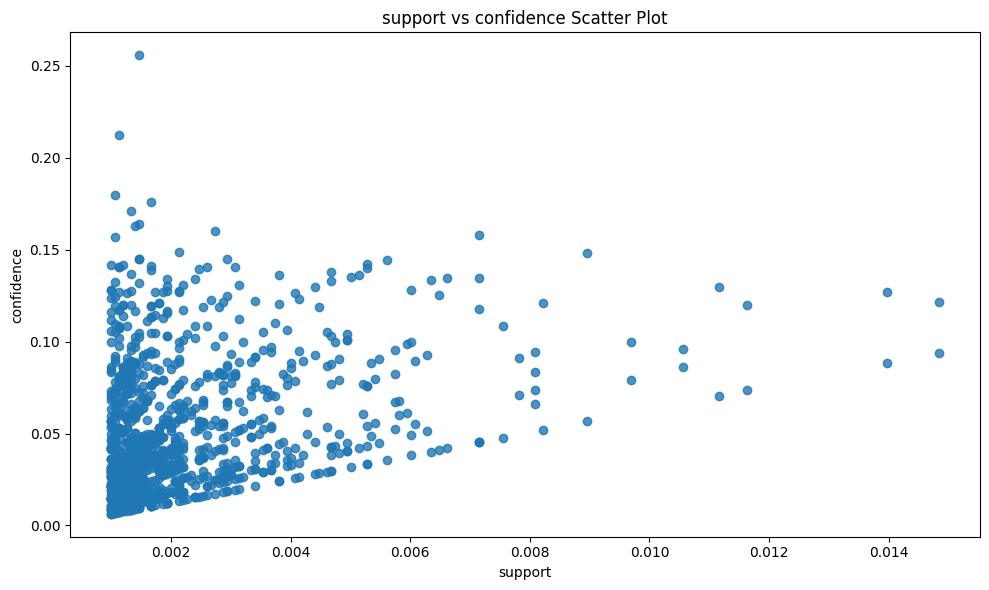

In [43]:
plot_rule_scatter(rules, x = 'support', y = 'confidence')

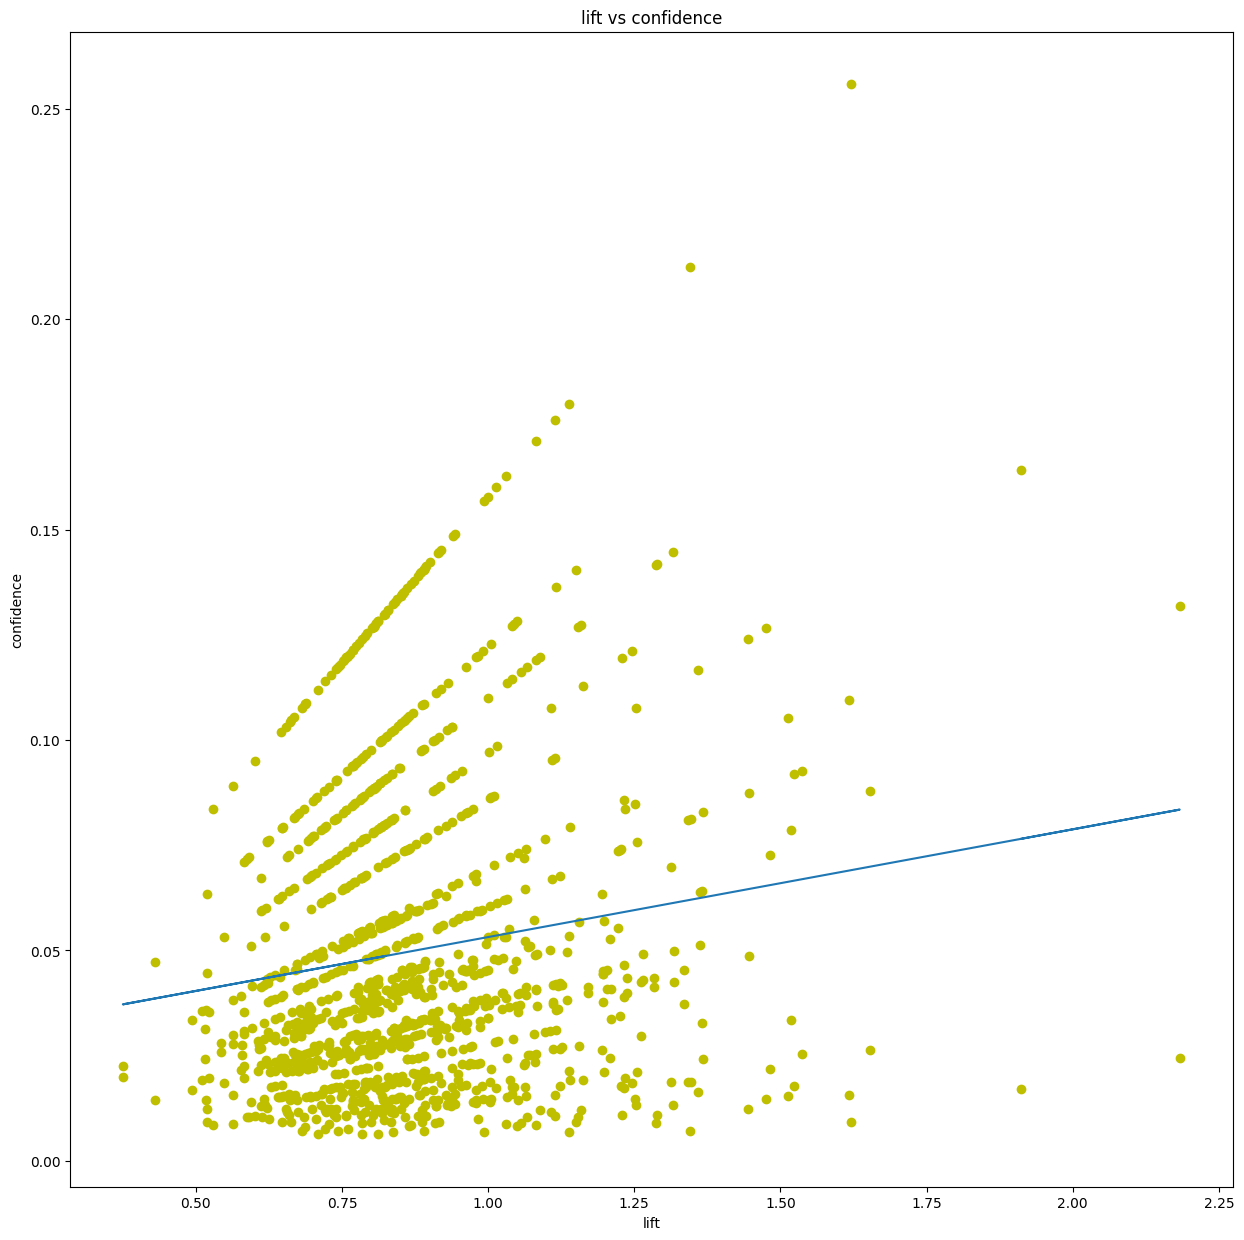

In [44]:
plot_rule_polyfit(rules, x = 'lift', y = 'confidence')